# Model development

This notebook is intended for the development of price forecasting models and is organised as follows
- Section 1: Data is prepared and features (exogenous variables) are chosen/created
- Section 2: Electricity prices are modelled as an autoregressive time series with linear and non-linear dependence on the autoregressive terms and exogenous variables ("linear ARX model")

## 1.1 Data preparation

Load data:

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
plt.style.use('seaborn-v0_8-colorblind')

from electricity_pricing.data.loading import load_and_merge_datasets

# read from CSVs
base_dir = os.path.join(os.path.dirname(os.getcwd()), "data", "processed")
df = load_and_merge_datasets(
    electricity_path=os.path.join(base_dir, "electricity_data.csv"),
    forecast_path=os.path.join(base_dir, "forecast_data.csv"),
    date_range=(datetime.date(2021, 1, 2), datetime.date(2024, 12, 31)),
    validate=True,
    verbose=False
)

# Create timezone-aware timestamps and set them as the index
df['timestamp_utc'] = (df['SETTLEMENT_DATE'] + pd.to_timedelta((df['SETTLEMENT_PERIOD'] - 1) * 30, unit='m')).dt.tz_localize('UTC')
df['DATETIME'] = df['timestamp_utc'].dt.tz_convert('Europe/London')
df.drop(columns=['timestamp_utc'], inplace=True)
df = df.sort_values(by='DATETIME', ascending=True).reset_index(drop=True)
df.set_index('DATETIME', inplace=True)

assert not df.isna().values.any(), "DataFrame has NaN values."

print(f"Dataset shape: {len(df)} rows, {len(df.columns)} columns")
df.head()

Dataset shape: 67920 rows, 25 columns


,SETTLEMENT_DATE,SETTLEMENT_PERIOD,BIOMASS,GAS,COAL,OIL,NUCLEAR,SOLAR,WIND,OTHER,...,naturalGasPrice,DEMAND_FORECAST,EMBEDDED_WIND_FORECAST,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_FORECAST,EMBEDDED_SOLAR_CAPACITY,Forecast_Datetime,DATETIME_GMT,WIND_CAPACITY,WIND_FORECAST
DATETIME,,,,,,,,,,,,,,,,,,,,,
2021-01-02 00:00:00+00:00,2021-01-02,1,2466.0,11176.0,0.0,0.0,5923.0,0.0,3817.661,570.0,...,19.578,26422.0,879,6527,0,13082,2021-01-01 08:12:00+00:00,2021-01-02 00:30:00+00:00,15729,2383
2021-01-02 00:30:00+00:00,2021-01-02,2,2467.0,11235.0,0.0,0.0,5929.0,0.0,3989.388,549.0,...,19.578,26622.0,867,6527,0,13082,2021-01-01 08:12:00+00:00,2021-01-02 01:00:00+00:00,15729,2382
2021-01-02 01:00:00+00:00,2021-01-02,3,2456.0,11461.0,0.0,0.0,5919.0,0.0,3912.158,652.0,...,19.578,26229.0,867,6527,0,13082,2021-01-01 08:12:00+00:00,2021-01-02 01:30:00+00:00,15729,2398
2021-01-02 01:30:00+00:00,2021-01-02,4,2463.0,10885.0,0.0,0.0,5932.0,0.0,3891.883,524.0,...,19.578,25836.0,863,6527,0,13082,2021-01-01 08:12:00+00:00,2021-01-02 02:00:00+00:00,15729,2429
2021-01-02 02:00:00+00:00,2021-01-02,5,2481.0,10643.0,0.0,0.0,5928.0,0.0,3907.977,525.0,...,19.578,25443.0,863,6527,0,13082,2021-01-01 08:12:00+00:00,2021-01-02 02:30:00+00:00,15729,2474


### 1.2 Feature Engineering

**Day-ahead forecasting setup**: At 09:00 on Day T, we forecast electricity prices for all settlement periods on Day T+1.

In our exploratory data analysis (see `exploratory_analysis.ipynb`), we inspected a number of variables and their relationship with electricity prices using actual historical data. Most of the variables we looked at appeared to be correlated with electricity prices, but some are redundant since we don't need to include both wind speed and wind generation for example. Additionally, we saw that electricity prices at time $t$ were autocorrelated with prices at earlier times, which suggests that we should use time-lagged electricity prices as autoregressive features in our models.

There are some restrictions on the available data for forecasted exogenous variables. It is possible to collect forecasts of electricity demand, wind and solar generation from the National Energy System Operator (NESO) website, as well as weather forecasts from the UK Met Office, but prices of futures contracts on goal and gas are often behind paywalls. Currently available (day-ahead) forecasted exogenous variables are:
- Electricity demand 
- Metered and embedded wind generation 
- Embedded solar generation
- Temporal information (weekends, holidays, etc.)

We will have to make our own forecasts or collect more data from public APIs if we want to include other exogenous variables.

**Autoregressive terms:** (see autocorrelation plots in `notebooks/exploratory_analysis.ipynb` for justification): 
- Lagged price from previous $p$ settlement periods
- Lagged price from previous day for the same settlement period
- Lagged price from same day on the previous week for the same settlement period

**Exogenous variables:**
- Suppressed demand: Use `demand_forecast - embedded_generation_forecast` since embedded generation effectively suppresses demand
- Metered wind generation
- Gas prices: We have daily mean gas prices - use Day T-1 prices for values on Day T+1 (can't use Day T since it contains information from after the time of forecasting)

**Temporal features**:
- Holidays
- Weekends

*Optional extensions:*
- Non-renewable generation forecasts using 7-day rolling averages
- Interaction terms, for example `gas_price * gas_generation`

In [2]:
from electricity_pricing.features import is_holiday, is_weekend, add_intercept
from electricity_pricing.utils import timeshift

df['SETTLEMENT_DATE'] = pd.to_datetime(df['SETTLEMENT_DATE'])

exog_config = {
    # Seasonal price lags (stay historical, not updated during forecasting)
    'price_lag_day': [1, 7], # day lags (same period on previous days)
    
    # Exogenous variables
    'suppressed_demand': True, # (demand - embedded generation) forecast
    'wind_gen': True, # wind generation forecast
    'gas_price': True,  # daily mean gas price (lagged 2 days)
    
    # Temporal features
    'is_holiday': True,
    'is_weekend': True,
    
    # Linear regression intercept
    'intercept': True,
}

exog_cols = []

if exog_config.get('price_lag_day'):
    day_lags = exog_config['price_lag_day']
    for dlag in day_lags:
        df[f'price_lag_day_{dlag}'] = timeshift(df['marketIndexPrice'], pd.Timedelta(days=-dlag))
        exog_cols.append(f'price_lag_day_{dlag}')

if exog_config.get('suppressed_demand'):
    df['suppressed_demand'] = (df['DEMAND_FORECAST'] - df['EMBEDDED_WIND_FORECAST'] - df['EMBEDDED_SOLAR_FORECAST'])
    exog_cols.append('suppressed_demand')

if exog_config.get('wind_gen'):
    df['wind_gen'] = df['WIND_FORECAST']
    exog_cols.append('wind_gen')

if exog_config.get('gas_price'):
    df['gas_price'] = timeshift(df['naturalGasPrice'], pd.Timedelta(days=-2))
    exog_cols.append('gas_price')

if exog_config.get('is_holiday'):
    df['is_holiday'] = is_holiday(df, 'SETTLEMENT_DATE', country='GB')
    exog_cols.append('is_holiday')

if exog_config.get('is_weekend'):
    df['is_weekend'] = is_weekend(df, 'SETTLEMENT_DATE')
    exog_cols.append('is_weekend')

if exog_config.get('intercept'):
    add_intercept(df, column_name='intercept', inplace=True)
    exog_cols.append('intercept')
    
# Drop any rows that have NaNs in the exogenous variables (usually due to lagging)
df[exog_cols] = df[exog_cols].ffill(limit=3)  # only fill up to 3 consecutive NaNs
df = df.dropna(subset=exog_cols)

# Separate target and exogenous features
exog = df[exog_cols].copy()
endog = df['marketIndexPrice'].copy()

assert not df.isna().values.any(), "DataFrame has NaN values."

print(f"Exogenous features shape: {exog.shape}")
print(f"Number of exogenous features: {len(exog_cols)}")
print(f"Target shape: {endog.shape}")
print(f"\nExogenous feature names: {exog_cols}")

Exogenous features shape: (63864, 8)
Number of exogenous features: 8
Target shape: (63864,)

Exogenous feature names: ['price_lag_day_1', 'price_lag_day_7', 'suppressed_demand', 'wind_gen', 'gas_price', 'is_holiday', 'is_weekend', 'intercept']


### 1.3 Test-train split

Spit the data into a training and testing set, and create feature matrix $\mathbf{X}$ and target vector $y$.

In [3]:
# Train-test split
from electricity_pricing.utils import train_test_split

train_range_str = ["2021-02-01", "2024-02-01"]
test_range_str = ["2024-02-02", "2024-12-01"]
train_range = [pd.to_datetime(ts).tz_localize("Europe/London") for ts in train_range_str]
test_range = [pd.to_datetime(ts).tz_localize("Europe/London") for ts in test_range_str]

exog_train, exog_test = train_test_split(exog, train_range, test_range)
endog_train, endog_test = train_test_split(endog, train_range, test_range)

# Check alignment
assert (exog_train.index == endog_train.index).all()
assert (exog_test.index == endog_test.index).all()

print(f"Training set shape: exog = {exog_train.shape}, endog = {endog_train.shape}")
print(f"Test set shape: exog = {exog_test.shape}, endog = {endog_test.shape}")
for T, feature_name in enumerate(exog_cols):
    print(f"  {T}: {feature_name}")

Training set shape: exog = (46912, 8), endog = (46912,)
Test set shape: exog = (14362, 8), endog = (14362,)
  0: price_lag_day_1
  1: price_lag_day_7
  2: suppressed_demand
  3: wind_gen
  4: gas_price
  5: is_holiday
  6: is_weekend
  7: intercept


## 2. ARX Models

### 2.1 Linear ARX

Let's propose an electricity pricing model of the form

$$
P_{t} = \sum^{\ell}_{k=1} \alpha_k P_{t - k} + \boldsymbol{\beta}^T \mathbf{X}^f_{t} + \epsilon_t,
$$

where
- $P_t$: price of electricity at time t
- $\mathbf{X}^f_t$: a vector of forecasted exogenous variables
- $\boldsymbol{\alpha}, \boldsymbol{\beta}$: some parameters
- $\epsilon_t$: noise term

The proposed model is an autoregressive model with exogenous variables (ARX) with a linear dependence on the parameters $\boldsymbol{\theta} = [\boldsymbol{\alpha}, \boldsymbol{\beta}]$. To find the parameters, we minimise the cost function
$$C = \sum_t (P_t  - \boldsymbol{\theta}^T \mathbf{Z}_t)^2,$$
where $\mathbf{Z}_t$ contains all the exogenous variables and autoregressive terms. The cost function is minimised by
$$\boldsymbol{\theta} = \left( \mathbf{Z}^T_t \mathbf{Z}_t \right)^{-1} \mathbf{Z}_t y_t$$
for all $t$. Once we have the parameters $\boldsymbol{\theta}$, we can use them to make predictions on the next price in the series.

In [4]:
# HELPER FUNCTIONS:
from electricity_pricing import evaluation_metrics as metrics
    
def evaluate_model(y_true, y_pred, dataset_name):
    rmse = metrics.rmse(y_true, y_pred)
    rel_rmse = metrics.relative_rmse(y_true, y_pred)
    mae = metrics.mae(y_true, y_pred)
    mape = metrics.mape(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print(f"\n{dataset_name} Set Metrics:")
    print(f"  RMSE: {rmse:.4f} £/MWh")
    print(f"  Relative RMSE: {rel_rmse:.4f}")
    print(f"  MAE:  {mae:.4f} £/MWh")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  R²:   {r2:.4f}")
    
    return {'rmse': rmse, 'rel_rse': rel_rmse, 'mae': mae, 'mape': mape, 'r2': r2}

Create an ARX model that uses linear regression to fit its parameters:

In [5]:
from electricity_pricing.models import ARXModel
from electricity_pricing.regressors import LinearRegression

# Create ARX model with 3 settlement period lags
model = ARXModel(lags=[1, 2, 3], regressor=LinearRegression())

Train the model:

In [6]:
# Train the model
model.fit(endog_train, exog_train)

coefficients = model.get_params()
feature_names = [f'price_lag_sp_{lag}' for lag in model.lags] + exog_cols
print(f"Model parameters: {len(feature_names)}")
for feature, coef in zip(feature_names, coefficients):
    print(f"  {feature:20s}= {coef:.2e}")

Model parameters: 11
  price_lag_sp_1      = 1.05e+00
  price_lag_sp_2      = -4.54e-02
  price_lag_sp_3      = -9.27e-02
  price_lag_day_1     = 3.35e-02
  price_lag_day_7     = 1.72e-02
  suppressed_demand   = 6.04e-05
  wind_gen            = -3.08e-04
  gas_price           = 8.43e-02
  is_holiday          = -1.86e+00
  is_weekend          = -9.32e-01
  intercept           = 1.89e+00


In [7]:
# Generate forecasts and evaluate performance
from electricity_pricing.forecast import forecast_day_ahead

print("\nForecasting on test set...")
forecast, actuals = forecast_day_ahead(model, endog_test, exog_test, skip_days=2)
print("Finished.")

test_metrics = evaluate_model(actuals, forecast, "Test")


Forecasting on test set...
Finished.

Test Set Metrics:
  RMSE: 24.4557 £/MWh
  Relative RMSE: 23.2707
  MAE:  18.2834 £/MWh
  MAPE: 153.40%
  R²:   0.3168


Plot predictions:

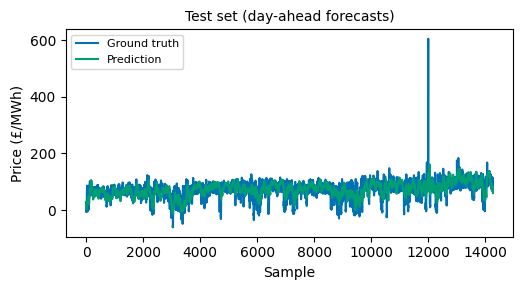

In [8]:
# Test set
fig, ax = plt.subplots(figsize=(16/3, 9/3), layout='tight')
ax.plot(actuals.values, label='Ground truth')
ax.plot(forecast.values, label='Prediction')
ax.set_xlabel('Sample', fontsize=10)
ax.set_ylabel('Price (£/MWh)', fontsize=10)
ax.set_title(f'Test set (day-ahead forecasts)', fontsize=10)
ax.legend(fontsize=8)
plt.show()

Plot residuals:

/var/folders/r2/fdwz5hy15238clh3yp9jsd5m0000gn/T/ipykernel_43202/3838032757.py:4: RuntimeWarning: divide by zero encountered in divide
  rel_residuals_test = (np.abs(residuals_test) / np.abs(actuals).values)


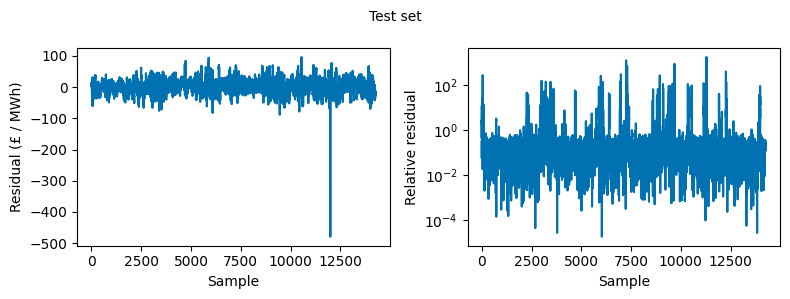

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

residuals_test = (forecast - actuals).values
rel_residuals_test = (np.abs(residuals_test) / np.abs(actuals).values)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16/2, 9/3), layout='tight')
plt.suptitle('Test set', fontsize=10)
# residuals
ax1.plot(residuals_test)
ax1.set_xlabel('Sample', fontsize=10)
ax1.set_ylabel('Residual (£ / MWh)', fontsize=10)
# relative residuals
ax2.plot(rel_residuals_test)
ax2.set_xlabel('Sample', fontsize=10)
ax2.set_ylabel('Relative residual', fontsize=10)
ax2.set_yscale('log')
plt.show()

Analyse residuals:

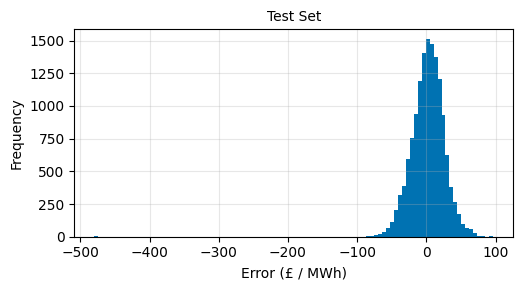

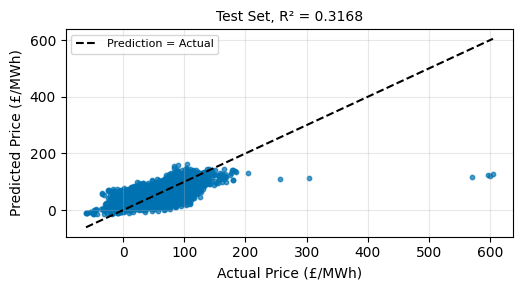

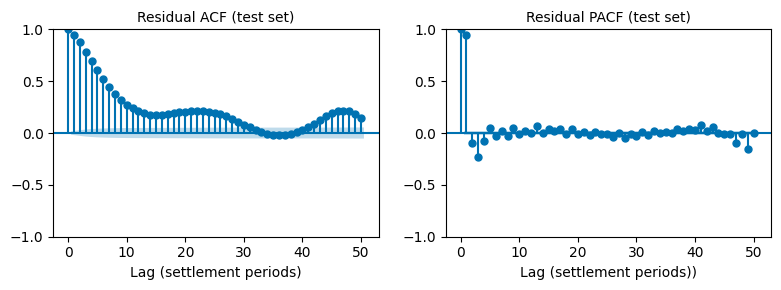

In [10]:
# histogram of errors
fig, ax = plt.subplots(figsize=(16/3, 9/3), layout='tight')
ax.hist(residuals_test, bins=100)
ax.set_xlabel('Error (£ / MWh)', fontsize=10)
ax.set_ylabel('Frequency', fontsize=10)
ax.set_title(f'Test Set', fontsize=10)
ax.grid(True, alpha=0.3)
plt.show()

# predicted vs actual prices
fig, ax = plt.subplots(figsize=(16/3, 9/3), layout='tight')
ax.scatter(actuals, forecast, alpha=0.7, s=10)
ax.set_xlabel('Actual Price (£/MWh)', fontsize=10)
ax.set_ylabel('Predicted Price (£/MWh)', fontsize=10)
ax.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], ls='--', color='black', label='Prediction = Actual')
ax.legend(fontsize=8)
ax.set_title(f'Test Set, R² = {test_metrics["r2"]:.4f}', fontsize=10)
ax.grid(True, alpha=0.3)
plt.show()

# residual auto-correlation and partial auto-correlations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16/2, 9/3), layout='tight')
plot_acf(residuals_test, lags=50, ax=ax1)
ax1.set_title('Residual ACF (test set)', fontsize=10)
ax1.set_xlabel('Lag (settlement periods)', fontsize=10)
plot_pacf(residuals_test, lags=50, ax=ax2)
ax2.set_title('Residual PACF (test set)', fontsize=10)
ax2.set_xlabel('Lag (settlement periods))', fontsize=10)
plt.show()

## 2.2 Regularised linear ARX

Let's explore regressors that use regularisation to reduce overfitting:

In [11]:
from sklearn.linear_model import Ridge, Lasso

model_ridge = ARXModel(lags=[1, 2, 3], regressor=Ridge(alpha=1.0, fit_intercept=False))
model_ridge.fit(endog_train, exog_train)

model_lasso = ARXModel(lags=[1, 2, 3], regressor=Lasso(alpha=0.1, max_iter=10000, fit_intercept=False))
model_lasso.fit(endog_train, exog_train)

print("Fitted models with Ridge and Lasso regression.")

Fitted models with Ridge and Lasso regression.


In [12]:
print("\nForecasting with Ridge regression on test set...")
forecast_ridge, _ = forecast_day_ahead(model_ridge, endog_test, exog_test, skip_days=2)
print("Finished.")

print("\nForecasting with Lasso regression on test set...")
forecast_lasso, _ = forecast_day_ahead(model_lasso, endog_test, exog_test, skip_days=2)
print("Finished.")

test_metrics_ridge = evaluate_model(actuals, forecast_ridge, "Test (Ridge)")
test_metrics_lasso = evaluate_model(actuals, forecast_lasso, "Test (Lasso)")


Forecasting with Ridge regression on test set...
Finished.

Forecasting with Lasso regression on test set...
Finished.

Test (Ridge) Set Metrics:
  RMSE: 24.4553 £/MWh
  Relative RMSE: 23.2695
  MAE:  18.2830 £/MWh
  MAPE: 153.39%
  R²:   0.3168

Test (Lasso) Set Metrics:
  RMSE: 24.3175 £/MWh
  Relative RMSE: 21.7694
  MAE:  18.0594 £/MWh
  MAPE: 141.27%
  R²:   0.3245


## 2.3 Non-linear ARX with XGBoost

The linear ARX model performs well, but we may be able to capture additional patterns using non-linear models.

In [13]:
from sklearn.ensemble import GradientBoostingRegressor

# Create ARX model with XGBoost regressor
xgb_regressor = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    random_state=42,
)

model_xgb = ARXModel(lags=[1, 2, 3], regressor=xgb_regressor)
model_xgb.fit(endog_train, exog_train)

print("XGBoost training complete.")

XGBoost training complete.


In [14]:
print("\nForecasting with XGBoost regressor on test set...")
forecast_xgb, _ = forecast_day_ahead(model_xgb, endog_test, exog_test, skip_days=2)
print("Finished.")

test_metrics_xgb = evaluate_model(actuals, forecast_xgb, "Test (XGB)")


Forecasting with XGBoost regressor on test set...
Finished.

Test (XGB) Set Metrics:
  RMSE: 23.4542 £/MWh
  Relative RMSE: 26.4728
  MAE:  16.2191 £/MWh
  MAPE: 176.95%
  R²:   0.3716


In [15]:
# Compare all models
print("\n" + "="*80)
print("MODEL COMPARISON - Test Set Performance")
print("="*80)

comparison = pd.DataFrame({
    'Model': ['Linear OLS', 'Ridge (alpha=1.0)', 'Lasso (alpha=0.1)', 'XGBoost'],
    'RMSE (£/MWh)': [
        test_metrics['rmse'], 
        test_metrics_ridge['rmse'], 
        test_metrics_lasso['rmse'],
        test_metrics_xgb['rmse']
    ],
    'MAE (£/MWh)': [
        test_metrics['mae'], 
        test_metrics_ridge['mae'], 
        test_metrics_lasso['mae'],
        test_metrics_xgb['mae']
    ],
    'MAPE (%)': [
        test_metrics['mape'], 
        test_metrics_ridge['mape'], 
        test_metrics_lasso['mape'],
        test_metrics_xgb['mape']
    ],
    'R²': [
        test_metrics['r2'], 
        test_metrics_ridge['r2'], 
        test_metrics_lasso['r2'],
        test_metrics_xgb['r2']
    ]
})

print(comparison.to_string(index=False))
print("="*80)


MODEL COMPARISON - Test Set Performance
            Model  RMSE (£/MWh)  MAE (£/MWh)   MAPE (%)       R²
       Linear OLS     24.455700    18.283378 153.397734 0.316774
Ridge (alpha=1.0)     24.455300    18.283013 153.388765 0.316797
Lasso (alpha=0.1)     24.317522    18.059446 141.274278 0.324473
          XGBoost     23.454180    16.219121 176.946944 0.371588


In [16]:
# Compare coefficients across the linear models
feature_names = list(exog.keys())

coef_comparison = pd.DataFrame({
    'Linear OLS': model.get_params(),
    'Ridge (alpha=1.0)': model_ridge.get_params(),
    'Lasso (alpha=0.1)': model_lasso.get_params()
})

print("\n" + "="*80)
print("Linear model coefficients")
print("="*80)
print(coef_comparison.to_string(index=False))
print("="*80)


Linear model coefficients
 Linear OLS  Ridge (alpha=1.0)  Lasso (alpha=0.1)
   1.049093           1.049093           1.048934
  -0.045409          -0.045409          -0.045494
  -0.092668          -0.092668          -0.092062
   0.033491           0.033491           0.033412
   0.017192           0.017192           0.017251
   0.000060           0.000060           0.000114
  -0.000308          -0.000308          -0.000280
   0.084311           0.084313           0.086067
  -1.864928          -1.863081          -0.000000
  -0.931538          -0.931273          -0.164666
   1.891298           1.890228           0.000000


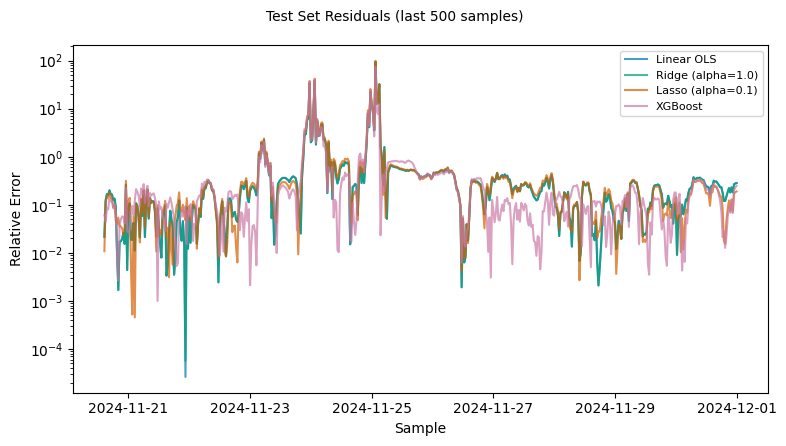

In [17]:
# Visualise prediction errors

rel_err = lambda pred, truth : np.sqrt((pred - truth)**2 / truth**2)

models = [
    (rel_err(forecast, actuals), 'Linear OLS'),
    (rel_err(forecast_ridge, actuals), 'Ridge (alpha=1.0)'),
    (rel_err(forecast_lasso, actuals), 'Lasso (alpha=0.1)'),
    (rel_err(forecast_xgb, actuals), 'XGBoost')
]

fig, ax = plt.subplots(figsize=(16/2, 9/2), layout='tight')
for (residuals, label) in models:
    ax.plot(residuals[-500:], label=label, alpha=0.7)
ax.set_xlabel('Sample', fontsize=10)
ax.set_ylabel('Relative Error', fontsize=10)
ax.legend(fontsize=8)
ax.set_yscale('log')
plt.suptitle('Test Set Residuals (last 500 samples)', fontsize=10)
plt.show()